<a href="https://colab.research.google.com/github/shivamsaxena17493/Machine-Learning-Practice/blob/master/Text%20Analytics/Yelp%20Reviews%20Scraping%2C%20Sentiment%20Analysis%20%2C%20Modeling%20%26%20Evaluation/Yelp_Review_Sentiment_Analysis_%26_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yelp Review Sentiment Analysis & Modeling


### Import Packages

In [0]:
# for web scraping
import urllib.request
import bs4

# for numerical conversion and model input data preparation
import numpy as np
import pandas as pd 

# for preprocessing
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
# train test data preparation for model
from sklearn.model_selection import train_test_split

# classification models for text classification

# Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
# Support Vector Machines Model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
# for finding best performing model parameters
from sklearn.model_selection import GridSearchCV


# for model evaluation and interpretation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import cohen_kappa_score


# for data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from collections import Counter

    

# Scapping Reviews for 2 categories
from http://mlg.ucd.ie/modules/yalp/ 

Below are the essential function required to scrape consumer reviews from a set of web pages.



In [0]:
index_link = "http://mlg.ucd.ie/modules/yalp/"

In [0]:
def getHTMLSoup(link):
    """
      Description of the getHTMLSoup Function
      
      This function returns the html parsed soup object for the given link.

      Parameters:
        link (str): it will be the link for which soup object is required.

      Returns:
        html_parsed_soup object : it will contain the Soup parsed html object

    """
    try:
        response = urllib.request.urlopen(link)
    except:
        print("Error Occured: Page not Found status {}".format(response.code))
    if response.code == 200:
        html = response.read().decode()
        parsed_html_soup = bs4.BeautifulSoup(html,"html.parser")
        
    return parsed_html_soup

In [0]:
def getCategoriesLinkFromIndex(index_soup, categories):
    """
    Description of the getCategoriesLinkFromIndex Function
    
    This function returns the links of page where reviews are published.

    Parameters:
      index_soup (soup object): parsed html soup object of the index page
      categories (list): list of categories for which review page links are extracted

    Returns:
      categories_links (dictionary): links of review pages
    
    """
    categories_links = {}

    for match in index_soup.find_all("h4"):
        category_title = match.get_text().replace(u'\xa0', u' ').split(":")[1].split("  ")[0].strip()
        if category_title in categories:
            categories_links[category_title] = index_link + match.find('a').get('href')

    return categories_links

In [0]:
index_soup = getHTMLSoup(index_link)

In [0]:
index_soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta content="noindex" name="robots">
<meta content="Content on this site is posted for teaching purposes only. Original data is from yelp.com" name="description">
<meta charset="utf-8">
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<meta content="width=device-width, initial-scale=1" name="viewport">
<title>Yalp Reviews — Home</title>
<link href="images/favicon.ico" rel="shortcut icon">
<!-- Bootstrap core CSS -->
<link href="assets/css/bootstrap.css" rel="stylesheet">
<!-- Custom styles for this template -->
<link href="assets/css/style.css" rel="stylesheet">
<link href="assets/css/font-awesome.min.css" rel="stylesheet">
<script src="assets/js/modernizr.js"></script>
</link></link></link></link></meta></meta></meta></meta></meta></head>
<body>
<div class="container mtb">
<div class="row">
<div class="col-md-12">
<h3 class="info">Yalp Reviews — Home</h3>
</div>
</div>
<div class="row">
<div class="col-md-10" name="main">
<div class="cat

### Selection of Categories - Hotels & Travel and Restaurants

In [0]:
categories = ["Hotels and travel","Restaurants"]

In [0]:
categories_links = getCategoriesLinkFromIndex(index_soup,categories)
categories_links

{'Hotels and travel': 'http://mlg.ucd.ie/modules/yalp/hotels_travel_list.html',
 'Restaurants': 'http://mlg.ucd.ie/modules/yalp/restaurants_list.html'}

In [0]:
business_list_soup = getHTMLSoup(categories_links['Hotels and travel'])
business_list_soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta content="noindex" name="robots">
<meta content="Content on this site is posted for teaching purposes only. Original data is from yelp.com" name="description">
<meta charset="utf-8">
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<meta content="width=device-width, initial-scale=1" name="viewport">
<title>Yalp — Fresh Reviews for Hotels and travel</title>
<link href="images/favicon.ico" rel="shortcut icon">
<!-- Bootstrap core CSS -->
<link href="assets/css/bootstrap.css" rel="stylesheet">
<!-- Custom styles for this template -->
<link href="assets/css/style.css" rel="stylesheet">
<link href="assets/css/font-awesome.min.css" rel="stylesheet">
<script src="assets/js/modernizr.js"></script>
</link></link></link></link></meta></meta></meta></meta></meta></head>
<body>
<div class="container mtb">
<div class="row">
<div class="col-md-12">
<h3 class="info">Yalp — Fresh Reviews for Hotels and travel</h3>
</div>
</div>
<div class="row">
<div 

### Scrape all reviews for each category 



In [0]:
def getReviewsLinksForCategory(categories_links):
    """
    Description of the getReviewsLinksForCategory Function

    This function returns the links of page where reviews are published.

    Parameters:
      categories_links (dictionary): dictionary of categories page links 

    Returns:
      category_reviews_links (dictionary): dictionary containing links of review pages 
                    with category, business name and tags.

    """
    category_reviews_links = {}
    
    for category,link in categories_links.items():
        
        # getting html parsed soup object for review page link
        category_html_soup = getHTMLSoup(link)
        
        # initialization of category in dictionary
        category_reviews_links[category] = {}
        
        # for each business get the <p> tag
        for biz in category_html_soup.findAll('p'):
            
            # getting name of the business 
            business_name = biz.find('a').getText().strip()
                        
            # getting the tags in which business is involved
            tags = biz.findAll('br')[0].getText()
            
            main_link = link.split('yalp')[0]
            
            # storing the link and tags to specific business and category
            category_reviews_links[category][business_name] = [main_link + 'yalp/' + biz.find('a').get('href'),tags]
            
    return category_reviews_links

In [0]:
cat_reviews_links = getReviewsLinksForCategory(categories_links)

In [0]:
cat_reviews_links

{'Hotels and travel': {'Aeroport Taxi & Limousine Service': ['http://mlg.ucd.ie/modules/yalp/reviews_Nip4TJZjarrZv2lrPA0YBw.html',
   'Hotels & Travel, Airport Shuttles, Transportation, Taxis, Limos, Airports'],
  'Air Canada': ['http://mlg.ucd.ie/modules/yalp/reviews_i8vUkYPbaXON_42F-bu4pQ.html',
   'Transportation, Airlines, Hotels & Travel'],
  'Airmiles Customer Service': ['http://mlg.ucd.ie/modules/yalp/reviews_o9HuejkSCUgoXnvkihGx2w.html',
   'Travel Services, Hotels & Travel'],
  'Allegiant Airlines': ['http://mlg.ucd.ie/modules/yalp/reviews_RYfY6Y2PGVF08Vq2TdDZ-Q.html',
   'Transportation, Hotels & Travel, Airlines'],
  'Aria Sky Suites': ['http://mlg.ucd.ie/modules/yalp/reviews_E-6l98hX8jICTF6rKHxI8g.html',
   'Hotels, Event Planning & Services, Hotels & Travel'],
  'Arizona Balloon Safaris': ['http://mlg.ucd.ie/modules/yalp/reviews_YFj05UteXLZ_ntk709REAA.html',
   'Tours, Hotels & Travel'],
  'Auberge De La Place Royale': ['http://mlg.ucd.ie/modules/yalp/reviews_pnGOezHAOkzk8

In [0]:
cat_reviews_links = getReviewsLinksForCategory(categories_links)


In [0]:
cat_reviews_links.keys()

dict_keys(['Hotels and travel', 'Restaurants'])

### For each review, adding class label 

* Adding Column Class based on star rating:
    * __Positive__ - greater than 3 star - 1
    * __Negative__ - less than 4 star - 0

In [0]:

def getReviewsDataForCategory(category_links):
    
    # list of values for each review of each category
    data_list = []
    
    for business, link_tags in category_links.items():
        
        review_page_link, biz_tags = link_tags
        
        # to get all reviews published on category page
        all_reviews = getHTMLSoup(review_page_link).findAll("div", {"class": "review"})
        
        # for each review, storing various attributes
        for review in all_reviews:
            
            # to get the revew text
            review_text = review.find('p',{'class':'text'}).getText()
            
            # to get the number of stars 
            rating = int(review.find('img').get('alt').split('-')[0])
            
            # adding class label if stars are less than 4 then negative else positive
            if rating > 3: 
                data_list.append([business, biz_tags, review_text,rating, 1])
            else: 
                data_list.append([business, biz_tags, review_text,rating, 0])
                
    return data_list


### Store them as two separate datasets. 



__For Hotels & Travel__

In [0]:
hotels_travels_dat = getReviewsDataForCategory(cat_reviews_links['Hotels and travel'])

In [0]:
hotels_travels_sentiment_df = pd.DataFrame(hotels_travels_dat,
                                    columns=['business_name','tags','review_text','rating', 'class'])

In [0]:
hotels_travels_sentiment_df.shape

(1410, 5)

In [0]:
hotels_travels_sentiment_df.head()

,business_name,tags,review_text,rating,class
0,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",I have used this service before and was satisf...,1,0
1,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",First time I tried using them the driver was n...,1,0
2,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",Driver picked me up on time at 6AM and even kn...,5,1
3,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",First time using this taxi and limo company as...,5,1
4,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",Great experience. Driver was early and was ver...,5,1


In [0]:
hotels_travels_sentiment_df.to_csv('hotels_and_travel_yelp_data.csv', encoding='utf-8', index=False)

__For Restaurants__

In [0]:
restaurants_dat = getReviewsDataForCategory(cat_reviews_links['Restaurants'])

In [0]:
restaurants_sentiment_df = pd.DataFrame(restaurants_dat,
                                    columns=['business_name','tags','review_text','rating', 'class'])

In [0]:
restaurants_sentiment_df.shape

(1440, 5)

In [0]:
restaurants_sentiment_df.head()

,business_name,tags,review_text,rating,class
0,Au Festin de Babette,"Ice Cream & Frozen Yogurt, Breakfast & Brunch,...",Too expensive for what they had... i had an eg...,2,0
1,Au Festin de Babette,"Ice Cream & Frozen Yogurt, Breakfast & Brunch,...","Very rustic place. Mismatched furniture, off K...",4,1
2,Au Festin de Babette,"Ice Cream & Frozen Yogurt, Breakfast & Brunch,...",I highly recommend Au Festin de Babette for th...,5,1
3,Au Festin de Babette,"Ice Cream & Frozen Yogurt, Breakfast & Brunch,...",Amazing soup and dauphinoise. BUT the wait for...,3,0
4,Au Festin de Babette,"Ice Cream & Frozen Yogurt, Breakfast & Brunch,...",I went here by recommendation of a friend. Tho...,2,0


In [0]:
restaurants_sentiment_df.to_csv('restaurants_yelp_data.csv', encoding='utf-8', index=False)

In [0]:
def plotStarsDistribution(df,col_name,category):
    x=df[col_name].value_counts()
    x=x.sort_index()
    plt.figure(figsize=(8,8))
    ax= sns.barplot(x.index, x.values, alpha=0.8)
    plt.title("Reviews Star Rating Distribution for {}".format(category))
    plt.ylabel('No. of Reviews', fontsize=15)
    plt.xlabel('Star Ratings ', fontsize=15)

    #adding the text labels
    rects = ax.patches
    labels = x.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

    plt.show()




# Data Analysis

For both category datasets:
    
    
__From the reviews in this category, apply appropriate preprocessing steps
to create a numeric representation of the data, suitable for classification.__



In [0]:
hotels_travels_sentiment_df.shape

(1410, 5)

In [0]:
hotels_travels_sentiment_df['rating'].value_counts()

5    534
1    440
4    248
2    121
3     67
Name: rating, dtype: int64

## Hotels and Travels dataset  analysis

* Positive = 782 or 55.4%
* Negative = 628 or 44.6%

__Positive class tuples are 10% more than negative which would impact the model training but by much.__

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


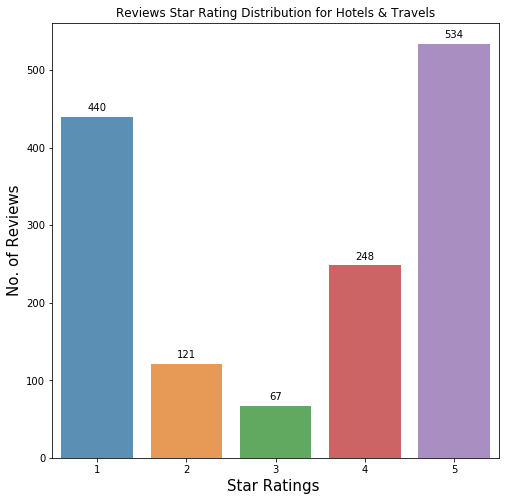

In [0]:
plotStarsDistribution(hotels_travels_sentiment_df,'rating','Hotels & Travels')

In [0]:
restaurants_sentiment_df['rating'].value_counts()

5    598
4    335
1    235
2    176
3     96
Name: rating, dtype: int64

In [0]:
restaurants_sentiment_df.shape

(1440, 5)

## Restaurant Dataset class data analysis
* Positive = 933 or 64.7%
* Negative = 507 or 35.3% 


* __Positive class tuples are 30% more than Negative class tuples__
* __There is class imbalance in restaurant positive and negative data which will impact the model training. Also will increase bias towards positive class in predictions__
* __Have to resample the dataset__


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


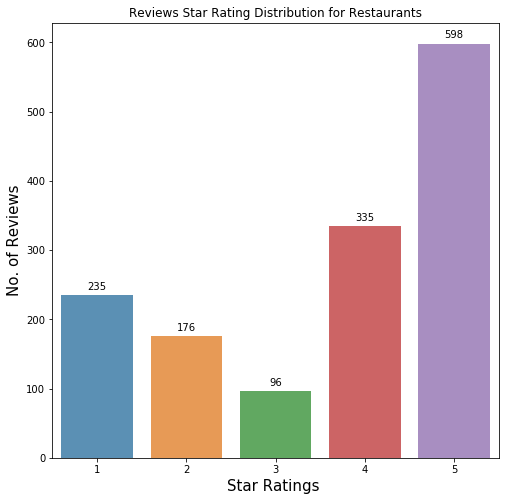

In [0]:
plotStarsDistribution(restaurants_sentiment_df,'rating','Restaurants')

In [0]:
hotels_travels_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 5 columns):
business_name    1410 non-null object
tags             1410 non-null object
review_text      1410 non-null object
rating           1410 non-null int64
class            1410 non-null int64
dtypes: int64(2), object(3)
memory usage: 55.2+ KB


### Adding new feature text length

In [0]:
hotels_travels_sentiment_df['text length'] = hotels_travels_sentiment_df['review_text'].apply(len)

In [0]:
restaurants_sentiment_df['text length'] = restaurants_sentiment_df['review_text'].apply(len)

In [0]:
hotels_travels_sentiment_df.head()

,business_name,tags,review_text,rating,class,text length
0,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",I have used this service before and was satisf...,1,0,3250
1,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",First time I tried using them the driver was n...,1,0,1112
2,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",Driver picked me up on time at 6AM and even kn...,5,1,253
3,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",First time using this taxi and limo company as...,5,1,281
4,Aeroport Taxi & Limousine Service,"Hotels & Travel, Airport Shuttles, Transportat...",Great experience. Driver was early and was ver...,5,1,136


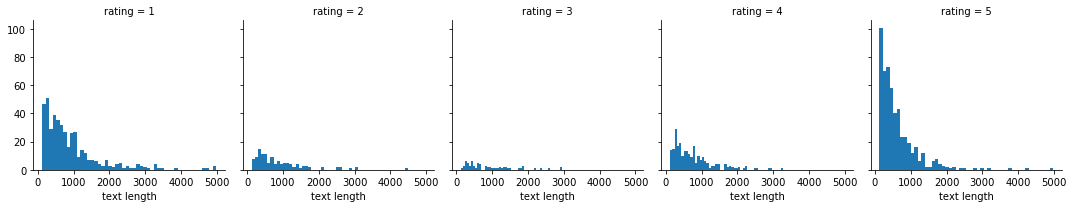

In [0]:
g = sns.FacetGrid(data=hotels_travels_sentiment_df, col='rating')
g.map(plt.hist, 'text length', bins=50)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


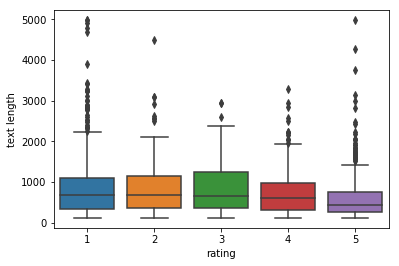

In [0]:
sns.boxplot(x='rating', y='text length', data=hotels_travels_sentiment_df)

### DataSet Separation X and y for both Categories

__For Hotels and Travels Category__

In [0]:
X_hotels_travels = hotels_travels_sentiment_df['review_text']
y_hotels_travels = hotels_travels_sentiment_df['class']

__For Restaurant Category__

In [0]:
X_restaurants = restaurants_sentiment_df['review_text']
y_restaurants = restaurants_sentiment_df['class']

In [0]:
X_hotels_travels.head()

0    I have used this service before and was satisf...
1    First time I tried using them the driver was n...
2    Driver picked me up on time at 6AM and even kn...
3    First time using this taxi and limo company as...
4    Great experience. Driver was early and was ver...
Name: review_text, dtype: object

In [0]:
y_hotels_travels.head()

0    0
1    0
2    1
3    1
4    1
Name: class, dtype: int64

### Preprocessing Steps

* __Tokenization using RegexTokenizer of nltk__
* __Punctuation removal to get only words__
* __Stop words are meaningless words which are only used to carry out sentence formation. Removing them will help get meaningful corpus of words__
* __Normalization of words to lowercase it will help make the count matrix more dense__

In [0]:
def preprocessReviewText(review_text):
    # tokenizing text into tokens using nltk lib function word_tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    
    # punctuations filtering from the text tokens 
    token_punc_removed = tokenizer.tokenize(review_text)
    
    # using stop word list published by SMART by Cornell University, 
    # SMART (System for the Mechanical Analysis and Retrieval of Text) 
    # containing 571 stop words.
    smart_stop_words = open('smart_stop_words.txt').read().split('\n')
    token_stopwords_removed = list(filter(lambda word: word.lower() not in set(smart_stop_words), token_punc_removed))
    
    # normalising all words to lowercase
    norm_tokens = [word.lower() for word in token_stopwords_removed if not word.isdigit()]
    return norm_tokens

### Creating feature vector for classification using Bag of words

* unique words will be represented by numeric value

In [0]:
def generateBOWforCategory(cat, X_cat ):
    # tokens with their frequencies
    # adding min_df = 3 , It will ignore all the tokens with frequency count less than 3.
    bow_transformer = CountVectorizer(analyzer=preprocessReviewText,min_df = 3).fit(X_cat)
    print("Vocabulary Length for Category {} is {}".format(cat, len(bow_transformer.vocabulary_)))
    # print(bow_transformer.get_feature_names())
    # for vectorisation process, 
    # To transform  X_cat dataframe into a sparse matrix using .transform() method 
    # on our bag-of-words transformed object
    bow_transformed = bow_transformer.transform(X_cat)
    print("Sparse Matrix of Bag of Words for Category {} \n".format(cat))

    print("Sparse Matrix Attributes: \n")
    print('Shape of Sparse Matrix for {}: {}'.format(cat, bow_transformed.shape))
    print('Amount of Non-Zero occurrences: ', bow_transformed.nnz)

    # Percentage of non-zero values
    density = (100.0 * bow_transformed.nnz / (bow_transformed.shape[0] * bow_transformed.shape[1]))
    print('Density: {}'.format((density)))
    return bow_transformed
  
  

### Reviews text to Vector Conversion using CountVecorizer() from scikit_learn


__A matrix of token counts, indicating how many instances of a particular word appear in a review.__

__it will end up as sparse matrix__

__For Hotel and Travels__

In [0]:
bow_hotels_travels_transformed = generateBOWforCategory("Hotels & Travel", X_hotels_travels)

Vocabulary Length for Category Hotels & Travel is 3691
Sparse Matrix of Bag of Words for Category Hotels & Travel 

Sparse Matrix Attributes: 

Shape of Sparse Matrix for Hotels & Travel: (1410, 3691)
Amount of Non-Zero occurrences:  58845
Density: 1.1306974411593467


__For Restaurants__

In [0]:
bow_restaurants_transformed = generateBOWforCategory("Restaurants", X_restaurants)

Vocabulary Length for Category Restaurants is 2957
Sparse Matrix of Bag of Words for Category Restaurants 

Sparse Matrix Attributes: 

Shape of Sparse Matrix for Restaurants: (1440, 2957)
Amount of Non-Zero occurrences:  47804
Density: 1.1226656145492804


### Training data and test data

As we have finished processing the review text in X, It’s time to split our X and y into a training and a test set using train_test_split from Scikit-learn. We will use 30% of the dataset for testing.

__For Hotel and Travels Category__

In [0]:
X_ht_train, X_ht_test, y_ht_train, y_ht_test = train_test_split(bow_hotels_travels_transformed,
                                                                y_hotels_travels, 
                                                                test_size=0.3, random_state=101)

__For Restaurants__


In [0]:
X_rest_train, X_rest_test, y_rest_train, y_rest_test = train_test_split(bow_restaurants_transformed,
                                                                y_restaurants, 
                                                                test_size=0.3, random_state=101)

## Classification models to distinguish between “positive” and “negative” reviews

__Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook__

### Testing and evaluating our model

In [0]:
def print_confusion_matrix(conf_mat, cls_names, fig_size = (6,4), font_size = 14 ):
    # conf_mat = confusion matrix will be ndarray passed
    # cls_names = list of classes
    df_cm = pd.DataFrame(conf_mat, index=cls_names, columns=cls_names)
    fig = plt.figure(figsize=fig_size)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels( heatmap.yaxis.get_ticklabels(), 
                                    rotation=0, ha='right', fontsize=font_size)

    heatmap.xaxis.set_ticklabels( heatmap.xaxis.get_ticklabels(), 
                                    rotation=45, ha='right', fontsize=font_size)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return fig

In [0]:
# Maintaing list for eval purpose
columns=['Category','Classifier', 'Precision','Recall','F1 Score', 'Accuracy']
eval_records =[]
model_list = {}
model_list['Hotels & Travels'] = []
model_list['Restaurants'] = []

In [0]:
def trainAndEvaluateClassifier(cat, clf_name, clf, X, y, X_test, y_test):
    # training the classifier
    clf.fit(X, y)
    
    print("For Category {} Evaluation Report for Classifier: {} \n".format(cat, clf_name))
    # collecting predictions on test data
    y_preds = clf.predict(X_test)
    print(classification_report(y_test, y_preds))
    
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    model_list[cat].append([clf_name,fpr,tpr,auc])
    
    accuracy = metrics.accuracy_score(y_test, y_preds)
    print("Accuracy: {} \n".format(str(accuracy)))
    
    precision, recall, fscore, support = score(y_test, y_preds,average='micro')
    
    print("Confusion Matrix ")
    class_names = ['Positive', 'Negative']
    cm = confusion_matrix(y_test, y_preds)
    print_confusion_matrix(cm, class_names)
    
    eval_records.append([cat, clf_name, precision, recall, fscore, accuracy])
    

In [0]:
def getBestParams(param_grid, clf, X_train, y_train):
    grid = GridSearchCV(clf, param_grid, cv=5)
    grid.fit(X_train, y_train)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    

### k-Nearest Neighbour Classifier


In [0]:
knn_param_grid = {'n_neighbors': [2, 3, 5, 7, 10]}
knn_clf = KNeighborsClassifier()
getBestParams(knn_param_grid, knn_clf, X_ht_train, y_ht_train)

Best cross-validation score: 0.69
Best parameters:  {'n_neighbors': 10}
Best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')


In [0]:
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

For Category Hotels & Travels Evaluation Report for Classifier: HT-KNN 

             precision    recall  f1-score   support

          0       0.65      0.61      0.63       201
          1       0.67      0.70      0.68       222

avg / total       0.66      0.66      0.66       423

Accuracy: 0.657210401891 

Confusion Matrix 


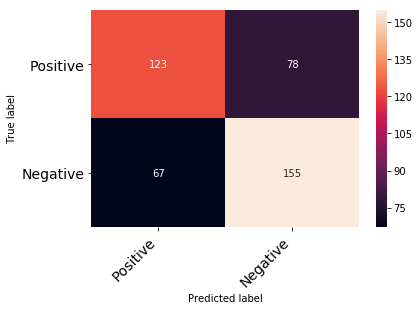

In [0]:
trainAndEvaluateClassifier('Hotels & Travels', 'HT-KNN',
                               knn_clf, X_ht_train, y_ht_train, X_ht_test, y_ht_test )

For Category Restaurants Evaluation Report for Classifier: R-KNN 

             precision    recall  f1-score   support

          0       0.49      0.70      0.57       145
          1       0.81      0.62      0.70       287

avg / total       0.70      0.65      0.66       432

Accuracy: 0.650462962963 

Confusion Matrix 


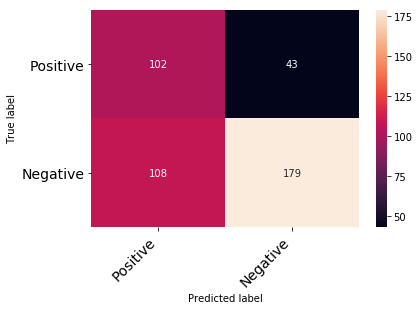

In [0]:
trainAndEvaluateClassifier('Restaurants', 'R-KNN',
                               knn_clf, X_rest_train, y_rest_train, X_rest_test, y_rest_test )

### Multinomial Naive Bayes Classifier

Training our model

Multinomial Naive Bayes is a specialised version of Naive Bayes designed more for text documents. Let’s build a Multinomial Naive Bayes model and fit it to our training set (X_train and y_train).

Next, let’s evaluate our predictions against the actual ratings (stored in y_test) using confusion_matrix and classification_report from Scikit-learn.

In [0]:
nb_clf = MultinomialNB()
nb_clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

__For Hotels and Travels__

For Category Hotels & Travels Evaluation Report for Classifier: HT-Multinomial Naive Bayes 

             precision    recall  f1-score   support

          0       0.89      0.80      0.84       201
          1       0.83      0.91      0.87       222

avg / total       0.86      0.86      0.86       423

Accuracy: 0.858156028369 

Confusion Matrix 


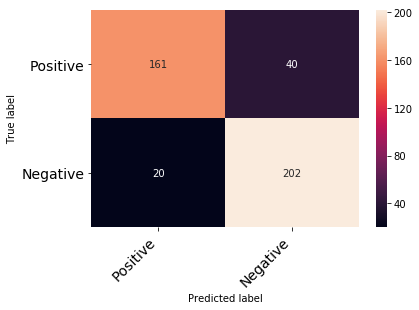

In [0]:
trainAndEvaluateClassifier('Hotels & Travels', 'HT-Multinomial Naive Bayes',
                               nb_clf, X_ht_train, y_ht_train, X_ht_test, y_ht_test )

__For Restaurants__

For Category Restaurants Evaluation Report for Classifier: R-Multinomial Naive Bayes 

             precision    recall  f1-score   support

          0       0.81      0.83      0.82       145
          1       0.91      0.90      0.91       287

avg / total       0.88      0.88      0.88       432

Accuracy: 0.877314814815 

Confusion Matrix 


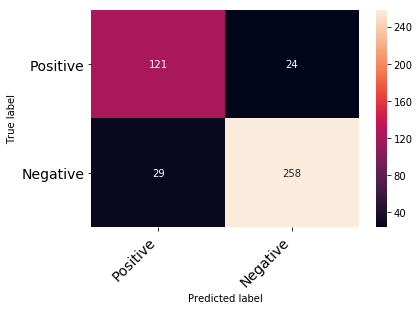

In [0]:
trainAndEvaluateClassifier('Restaurants', 'R-Multinomial Naive Bayes',
                               nb_clf, X_rest_train, y_rest_train, X_rest_test, y_rest_test )

### Logistic Regression Classifier

for high dimensional sparse data like ours, LogisticRegression often works best.

  * Grid Search: for paramater tuning of LogisticRegression. To determine what value of coefficeint ‘C’ provides better accuracy.
  
  * Cross validation: in order to avoid overfitting of data.

In [0]:
logreg_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg_clf = LogisticRegression()
getBestParams(logreg_param_grid, logreg_clf, X_ht_train, y_ht_train)

Best cross-validation score: 0.88
Best parameters:  {'C': 10}
Best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [0]:
lr_clf = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lr_clf

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

For Category Hotels & Travels Evaluation Report for Classifier: HT-Logistic Regression 

             precision    recall  f1-score   support

          0       0.91      0.79      0.85       201
          1       0.83      0.93      0.88       222

avg / total       0.87      0.86      0.86       423

Accuracy: 0.862884160757 

Confusion Matrix 


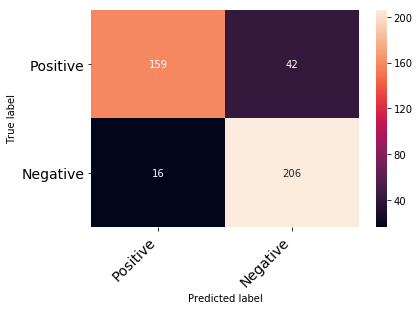

In [0]:
trainAndEvaluateClassifier('Hotels & Travels', 'HT-Logistic Regression',
                               lr_clf, X_ht_train, y_ht_train, X_ht_test, y_ht_test )

For Category Restaurants Evaluation Report for Classifier: R-Logistic Regression 

             precision    recall  f1-score   support

          0       0.78      0.77      0.78       145
          1       0.89      0.89      0.89       287

avg / total       0.85      0.85      0.85       432

Accuracy: 0.849537037037 

Confusion Matrix 


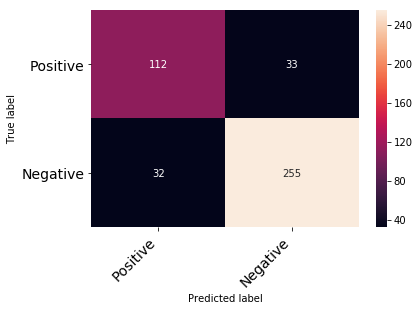

In [0]:
trainAndEvaluateClassifier('Restaurants', 'R-Logistic Regression',
                               lr_clf, X_rest_train, y_rest_train, X_rest_test, y_rest_test )

### RandomForest Classifier

In [0]:
rf_param_grid = {'n_estimators': [5, 10, 20, 30, 50, 70, 90]}
rf_clf = RandomForestClassifier()
getBestParams(rf_param_grid, rf_clf, X_ht_train, y_ht_train)

Best cross-validation score: 0.84
Best parameters:  {'n_estimators': 70}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [0]:
model_rfc = RandomForestClassifier(n_estimators = 90)
model_rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

For Category Hotels & Travels Evaluation Report for Classifier: HT-Random Forest 

             precision    recall  f1-score   support

          0       0.92      0.71      0.80       201
          1       0.78      0.95      0.86       222

avg / total       0.85      0.83      0.83       423

Accuracy: 0.832151300236 

Confusion Matrix 


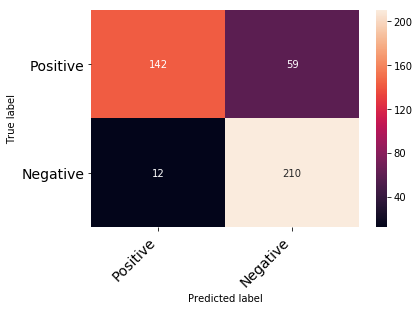

In [0]:
trainAndEvaluateClassifier('Hotels & Travels', 'HT-Random Forest',
                               model_rfc, X_ht_train, y_ht_train, X_ht_test, y_ht_test )

For Category Restaurants Evaluation Report for Classifier: R-Random Forest  

             precision    recall  f1-score   support

          0       0.81      0.66      0.73       145
          1       0.84      0.92      0.88       287

avg / total       0.83      0.83      0.83       432

Accuracy: 0.833333333333 

Confusion Matrix 


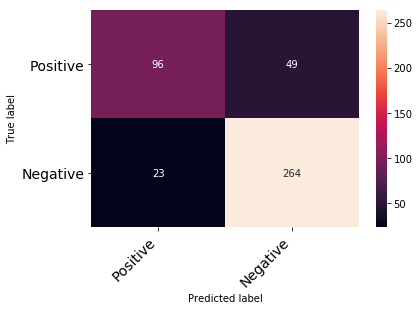

In [0]:
trainAndEvaluateClassifier('Restaurants', 'R-Random Forest ',
                               model_rfc, X_rest_train, y_rest_train, X_rest_test, y_rest_test )

### Gradient Boosting Classifier

In [0]:
model_gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
model_gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

For Category Hotels & Travels Evaluation Report for Classifier: HT-Gradient Boosting 

             precision    recall  f1-score   support

          0       0.94      0.72      0.81       201
          1       0.79      0.95      0.86       222

avg / total       0.86      0.84      0.84       423

Accuracy: 0.841607565012 

Confusion Matrix 


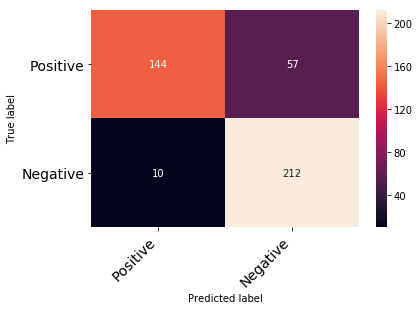

In [0]:
trainAndEvaluateClassifier('Hotels & Travels', 'HT-Gradient Boosting',
                               model_gb, X_ht_train.toarray(), y_ht_train, X_ht_test.toarray(), y_ht_test )

For Category Restaurants Evaluation Report for Classifier: R-Gradient Boosting 

             precision    recall  f1-score   support

          0       0.80      0.67      0.73       145
          1       0.85      0.91      0.88       287

avg / total       0.83      0.83      0.83       432

Accuracy: 0.831018518519 

Confusion Matrix 


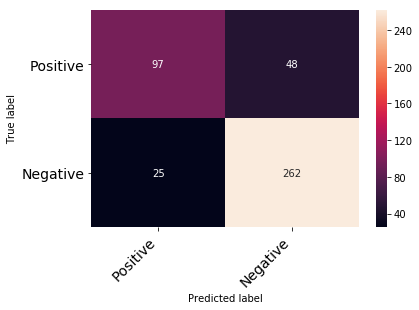

In [0]:
trainAndEvaluateClassifier('Restaurants', 'R-Gradient Boosting',
                               model_rfc, X_rest_train.toarray(), y_rest_train, X_rest_test, y_rest_test )

## ROC Analysis for All Models

In [0]:
def generateROC(model_list):
    plt.figure(figsize = (7,6),dpi = 100)
    plt.plot([0, 1], [0, 1])
    for i in range(0,len(model_list)):
        clf_name = model_list[i][0]
        fpr = model_list[i][1]
        tpr = model_list[i][2]
        auc = model_list[i][3]
        plt.plot(fpr,tpr,label="{}, auc={}".format( clf_name,str(auc)))
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC')
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

### Below are the ROC cureves for Hotels & Travels(HT) and Restaurants(R)

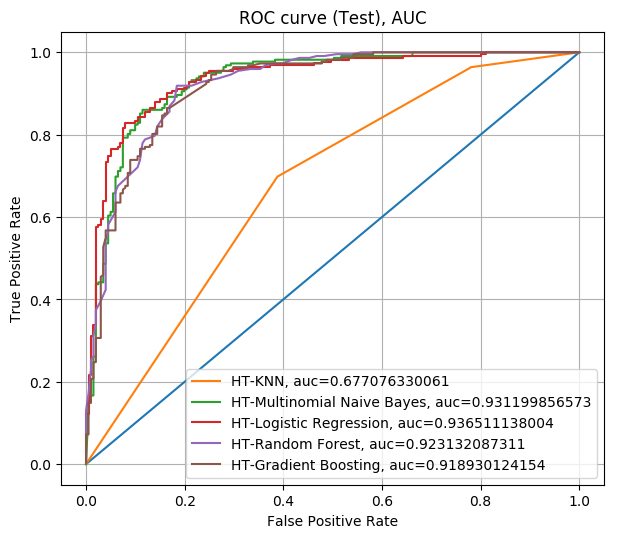

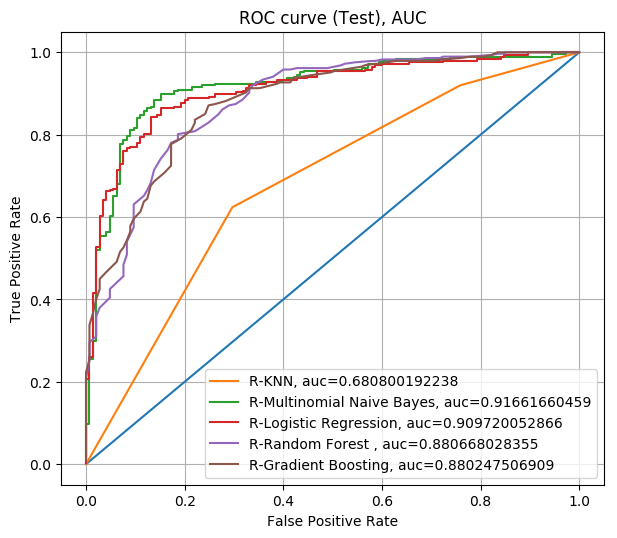

In [0]:
for cat in model_list.keys():
    generateROC(model_list[cat])

* For category Hotels & Travel, Logistic Regression Model Performed very well.
* For category Restaurants, Both Logitic Regression and Naive Bayes Performed better than other 3 Models.
* KNN performance was close the chance performance.

## Classifier Evaluation Comparison Results

In [0]:
results_df = pd.DataFrame(eval_records, columns=columns)

# Sort the rows of dataframe by column 'Name' inplace
results_df.sort_values(by='Accuracy' , ascending=False, inplace=True)

results_df

,Category,Classifier,Precision,Recall,F1 Score,Accuracy
3,Restaurants,R-Multinomial Naive Bayes,0.877315,0.877315,0.877315,0.877315
4,Hotels & Travels,HT-Logistic Regression,0.862884,0.862884,0.862884,0.862884
2,Hotels & Travels,HT-Multinomial Naive Bayes,0.858156,0.858156,0.858156,0.858156
5,Restaurants,R-Logistic Regression,0.849537,0.849537,0.849537,0.849537
8,Hotels & Travels,HT-Gradient Boosting,0.841608,0.841608,0.841608,0.841608
7,Restaurants,R-Random Forest,0.833333,0.833333,0.833333,0.833333
6,Hotels & Travels,HT-Random Forest,0.832151,0.832151,0.832151,0.832151
9,Restaurants,R-Gradient Boosting,0.831019,0.831019,0.831019,0.831019
0,Hotels & Travels,HT-KNN,0.657210,0.657210,0.657210,0.657210
1,Restaurants,R-KNN,0.650463,0.650463,0.650463,0.650463


## Observations

* From the ROC curve analysis It can be observed that KNN classifier performed the worst and Logistic Regression performed best.

* It can be infer that overall models performed better on Hotels & Travels category data than Restaurants category data.

* After analysing the confusion matrix of each model. Observed that there is class imbalance in Restaurant category data which degraded the recall performance of models.



# Evaluate how well your two classification models transfer between category.

In [0]:
# Maintaing list for eval purpose
columns=['Category','Classifier', 'Precision','Recall','F1 Score', 'Accuracy']
eval_records =[]
model_list = {}
model_list['Hotels & Travels'] = []
model_list['Restaurants'] = []

## Performing Experments with Logistic Regression

__Log Reg was best in 5 models tested in Task 2.__

In [0]:
lr_clf = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Train a classification model on the data from “Hotels & Travels”, and 
### evaluate its performance on the data from “Restaurants”.

In [0]:
bow_vec = CountVectorizer(analyzer=preprocessReviewText,min_df = 3)
bow_ht_transformed = bow_vec.fit_transform(X_hotels_travels)
transformed_for_rest = bow_vec.transform(X_restaurants)


In [0]:
X_rest_train, X_rest_test, y_rest_train, y_rest_test = train_test_split(transformed_for_rest, y_restaurants, 
                                                                test_size=0.3, random_state=101)

For Category Restaurants Evaluation Report for Classifier: Logistic Regression 

             precision    recall  f1-score   support

          0       0.75      0.80      0.78       145
          1       0.90      0.87      0.88       287

avg / total       0.85      0.84      0.85       432

Accuracy: 0.844907407407 

Confusion Matrix 


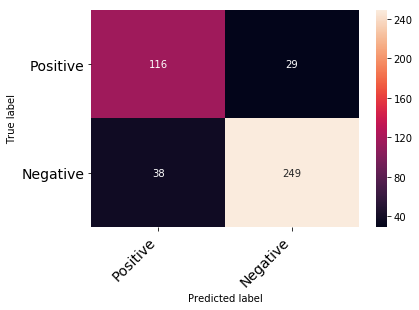

In [0]:
trainAndEvaluateClassifier('Restaurants', 'Logistic Regression',
                               lr_clf, X_rest_train, y_rest_train, X_rest_test, y_rest_test )

### Train a classification model on the data from “Restaurants”, and 
### evaluate its performance on the data from “Hotel & Travels”

In [0]:
bow_vec = CountVectorizer(analyzer=preprocessReviewText,min_df = 3)
bow_rest_transformed = bow_vec.fit_transform(X_restaurants)
transformed_for_ht = bow_vec.transform(X_hotels_travels)
lr_clf = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
X_ht_train, X_ht_test, y_ht_train, y_ht_test = train_test_split(transformed_for_ht, y_hotels_travels, 
                                                                test_size=0.3, random_state=101)

For Category Hotels & Travels Evaluation Report for Classifier: Logistic Regression 

             precision    recall  f1-score   support

          0       0.91      0.79      0.85       201
          1       0.83      0.93      0.88       222

avg / total       0.87      0.86      0.86       423

Accuracy: 0.862884160757 

Confusion Matrix 


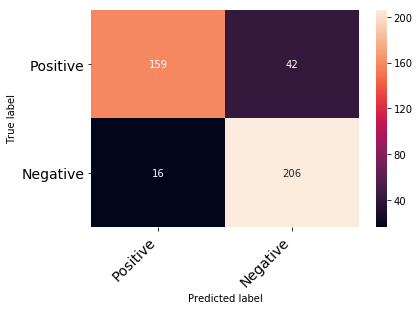

In [0]:
trainAndEvaluateClassifier('Hotels & Travels', 'Logistic Regression',
                               lr_clf, X_ht_train, y_ht_train, X_ht_test, y_ht_test )

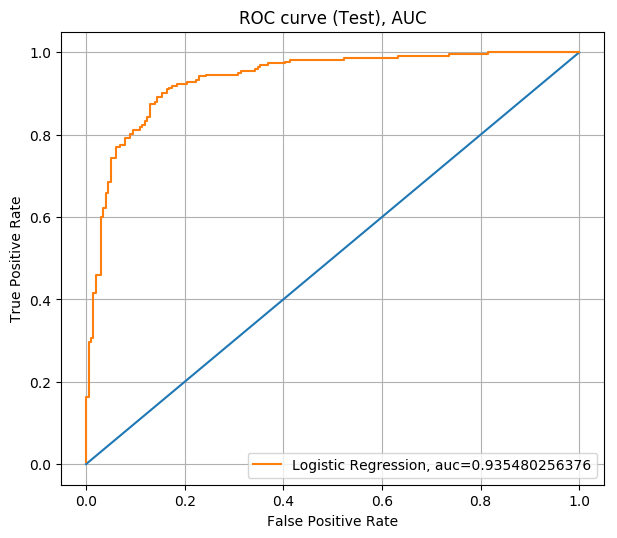

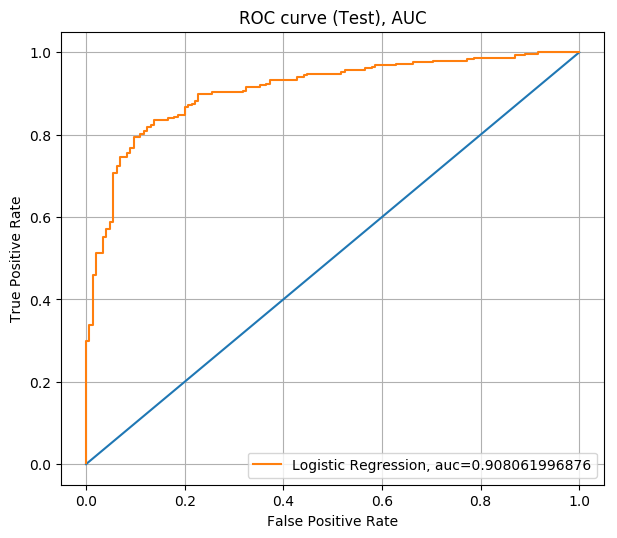

In [0]:
for cat in model_list.keys():
    generateROC(model_list[cat])

### Experiment Summary

In [0]:
results_df = pd.DataFrame(eval_records, columns=columns)

# Sort the rows of dataframe by column 'Name' inplace
results_df.sort_values(by='Accuracy' , ascending=False, inplace=True)

results_df

,Category,Classifier,Precision,Recall,F1 Score,Accuracy
1,Hotels & Travels,Logistic Regression,0.862884,0.862884,0.862884,0.862884
0,Restaurants,Logistic Regression,0.844907,0.844907,0.844907,0.844907


## Observation

*  In this particular case Models category transfer worked pretty well because hotels & travels is similar domain as other category Restaurants.

* This is not the valid way of comparison as the vocabulary it built upon won't be efficient to predict from text data of different domain

* vectorization significance will get decreased.

* Class imbalance in Restaurant category handling will lead to greater accuracy and imporve recall on other class as well.